**Author :** Vaibhav Thakur

# Kernel PCA from scratch

In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Dataset 
X = np.array([[1,1], [2,4], [-1,1], [-2,4]]).T
X

array([[ 1,  2, -1, -2],
       [ 1,  4,  1,  4]])

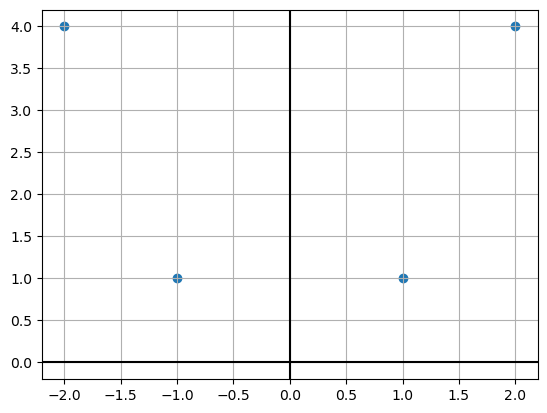

In [28]:
plt.scatter(X[0,:], X[1,:])
plt.axhline(c = 'k')
plt.axvline(c = 'k')
plt.grid()
plt.show();

## Step 1: Compute the Kernel Matrix

Compute the kernel matrix $K \in \mathbb{R}^{n \times n}$ using a kernel function where $$K_{ij} = k(x_i, x_j).$$

In [29]:
# Polynomial Kernel
def pol_ker(A, B, k):
    return (A.T@B + 1) ** k

K_pol = pol_ker(X, X, 2)


In [30]:
K_pol

array([[  9,  49,   1,   9],
       [ 49, 441,   9, 169],
       [  1,   9,   9,  49],
       [  9, 169,  49, 441]])

## Step 2: Center the Kernel Matrix

Center the kernel matrix using
$$
K_C = K - IK - KI + IKI,
$$
where  $I \in \mathbb{R}^{n \times n}$ is a matrix with all entries equal to $\frac{1}{n}$.


In [31]:
def ker_cen(K):
    n = K.shape[0]
    I = np.ones((n,n))*(1/n)
    return K - I@K - K@I + I@K@I

KC = ker_cen(K_pol)

## Step 3: Compute Eigenvectors and Eigenvalues

Compute the eigenvectors  $\{\beta_1, \beta_2, \ldots, \beta_n\}$ and eigenvalues $\{n\lambda_1, n\lambda_2, \ldots, n\lambda_n\}$ of the centered kernel matrix $K_C$.

Normalize the eigenvectors to obtain $$\forall u, \quad \alpha_u = \frac{\beta_u}{\sqrt{n\lambda_u}}.$$


In [32]:
lam, beta = np.linalg.eigh(KC)
lam, beta = lam[:: -1][:-1], beta[:,::-1][:,:-1]

# lam[:: -1][:-1] -> [::-1] reverses the array i.e. sorting the eignvalues in descending order and [:-1] drops 
# the last eignevalue i.e. the smallest eigenvalue

# beta[:,::-1][:,:-1] -> [:,::-1] keeps the rows as it is and reverses order of columns, i.e. ordering eigenvectors corresponding
# to the largest eigenvalue to the smallest; [:,:-1] drops the last column which is the eigenvector corresponding to the 
# smallest eigenvalue.

In [33]:
lam, beta

(array([277.9275172, 252.       ,   2.0724828]),
 array([[ 0.10365278, -0.5       , -0.69946844],
        [ 0.69946844,  0.5       ,  0.10365278],
        [-0.10365278, -0.5       ,  0.69946844],
        [-0.69946844,  0.5       , -0.10365278]]))

In [34]:
alpha = beta / np.sqrt(lam.reshape((1,-1)))
alpha

array([[ 0.00621749, -0.03149704, -0.48587288],
       [ 0.0419568 ,  0.03149704,  0.0720005 ],
       [-0.00621749, -0.03149704,  0.48587288],
       [-0.0419568 ,  0.03149704, -0.0720005 ]])

## Step 4: Project Data onto Kernel Principal Components

For each principal component $k$, compute$$\sum_{j=1}^n \alpha_{kj} K_{ij}^C, \quad \forall k.$$

Thus, each data point $x_i \in \mathbb{R}^d$ is mapped to
$$x_i \in \mathbb{R}^d \;\longrightarrow\;
\begin{bmatrix}
\sum_{j=1}^n \alpha_{1j} K_{ij}^C \\
\sum_{j=1}^n \alpha_{2j} K_{ij}^C \\
\vdots \\
\sum_{j=1}^n \alpha_{nj} K_{ij}^C
\end{bmatrix}.
$$


In [35]:
X_prime =  KC@alpha
X_prime

array([[  1.72801191,  -7.93725393,  -1.00696319],
       [ 11.66094908,   7.93725393,   0.14921979],
       [ -1.72801191,  -7.93725393,   1.00696319],
       [-11.66094908,   7.93725393,  -0.14921979]])

# Kernel PCA on Swiss Roll Dataset


## Step 1: Import libraries

In [36]:
from sklearn.datasets import make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D

## Step 2: Create Swiss Roll Dataset

In [37]:
def generate_swiss_roll(n_samples = 1000, noise = 0.2):
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))
    x = t * np.cos(t)
    y = 21 * np.random.rand(1, n_samples)
    z = t * np.sin(t)
    data = np.vstack((x, y, z)).T + noise * np.random.randn(n_samples, 3)
    return data

# Generate the Swiss Roll dataset

swiss_roll = generate_swiss_roll()

## Step 3: Visualize the Original Dataset

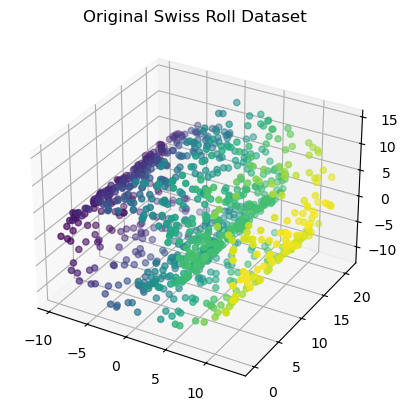

In [38]:
colors = swiss_roll[:, 0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(swiss_roll[:, 0], swiss_roll[:, 1], swiss_roll[:, 2], c = colors, cmap= 'viridis')
ax.set_title("Original Swiss Roll Dataset")
plt.show()

## Step 4: Define the Kernel Function
Kernel PCA relies on a kernel function. We'll use the Radial Basis Function (RBF) kernel, also known as the Gaussian kernel.<br>

**Radial Basis Function (RBF) / Gaussian Kernel**

The RBF (Gaussian) kernel is defined as $$k(x, x') = \exp\!\left( -\frac{\|x - x'\|^2}{2\sigma^2} \right),$$where $\sigma > 0$ is the bandwidth parameter.


In [39]:
def rbf_kernel(X, sigma=1.0):
    pairwise_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(X**2, axis=1) - 2 * np.dot(X, X.T)
    return np.exp(-pairwise_dists / (2 * sigma**2))

## Step 5: Implement Kernel PCA
For implementing Kernel PCA, we will perform the following steps:
- Compute the kernel matrix.
- Center the kernel matrix.
- Calculate the eigenvalues and eigenvectors of the centered kernel matrix.
- Sort the eigenvectors by decreasing eigenvalues.
- Select the top $k$ scaled eigenvectors as the new feature vectors.

In [40]:
def kernel_pca(X, n_components=2, sigma=1.0):
    # Compute the kernel matrix
    K = rbf_kernel(X, sigma)

    # Center the kernel matrix
    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    K_centered = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # Calculate eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eigh(K_centered)

    # Sort eigenvectors by decreasing eigenvalues
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # Select the top n_components scaled eigenvectors
    alphas = eigvecs[:, :n_components] / np.sqrt(eigvals[:n_components])

    return alphas

# Apply Kernel PCA to the Swiss Roll dataset
n_components = 2
alphas = kernel_pca(swiss_roll, n_components, sigma=1.0)

## Step 6: Visualize the Transformed Data


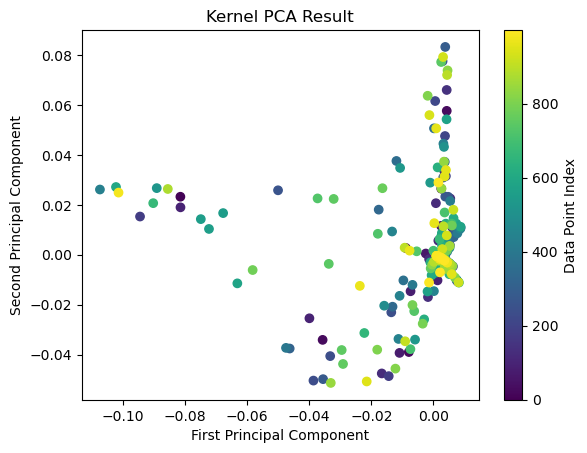

In [41]:
# Separate the transformed data into two components
pc1 = alphas[:, 0]
pc2 = alphas[:, 1]

# Create a scatter plot with two different colors for the two PCs
plt.scatter(pc1, pc2, c=range(len(pc1)))
plt.title("Kernel PCA Result")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.colorbar(label='Data Point Index')
plt.show()